In [69]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pratyushpuri/grocery-store-sales-dataset-in-2025-1900-record")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'grocery-store-sales-dataset-in-2025-1900-record' dataset.
Path to dataset files: /kaggle/input/grocery-store-sales-dataset-in-2025-1900-record


In [70]:
import os
import numpy as np
import pandas as pd
import kagglehub
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [71]:
files = os.listdir(path)
csv_file = [f for f in files if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(path, csv_file))

df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df = df.sort_values(['aisle','transaction_date'])

In [72]:
df.head()

,customer_id,store_name,transaction_date,aisle,product_name,quantity,unit_price,total_amount,discount_amount,final_amount,loyalty_points
257,8144,Corner Grocery,2023-08-08,Bakery,Cheese,5.0,23.46,117.30,0.00,117.30,471
1539,2499,GreenGrocer Plaza,2023-08-11,Bakery,Chicken Breast,3.0,13.16,39.48,7.90,31.58,228
1899,8483,QuickStop Market,2023-08-13,Bakery,Eggs,3.0,1.72,5.16,2.47,2.69,333
1637,2885,GreenGrocer Plaza,2023-08-24,Bakery,Pasta,3.0,18.84,56.52,0.00,56.52,276
350,9751,FreshMart Downtown,2023-08-27,Bakery,Yogurt,3.0,22.81,68.43,1.41,67.02,414


In [75]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

df_counts = df.groupby(['transaction_date', 'aisle']).size().reset_index(name='sales')

df_counts['day_of_week'] = df_counts['transaction_date'].dt.dayofweek
df_counts['month'] = df_counts['transaction_date'].dt.month
df_counts['day'] = df_counts['transaction_date'].dt.day
df_counts['is_weekend'] = df_counts['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

df_daily = df_counts.groupby('transaction_date').agg({
    'sales': 'sum',
    'day_of_week': 'first',
    'month': 'first',
    'is_weekend': 'first'
}).reset_index().sort_values('transaction_date')

print("Success! Data Cleaned with Date Features:")
print(df_daily.head())

Success! Data Cleaned with Date Features:
  transaction_date  sales  day_of_week  month  is_weekend
0       2023-08-07      2            0      8           0
1       2023-08-08      4            1      8           0
2       2023-08-11      2            4      8           0
3       2023-08-12      4            5      8           1
4       2023-08-13      3            6      8           1


In [84]:
print("📊 DATA CLEANING VERIFICATION")
print("-" * 30)
print(f"Total Daily Records: {len(df_daily)}")
print(f"Date Range: {df_daily['transaction_date'].min().date()} to {df_daily['transaction_date'].max().date()}")
print(f"Missing Values:\n{df_daily.isnull().sum()}")
print("-" * 30)
print("Preview of Cleaned Features:")
print(df_daily[['transaction_date', 'sales', 'day_of_week', 'is_weekend']].head())

📊 DATA CLEANING VERIFICATION
------------------------------
Total Daily Records: 689
Date Range: 2023-08-07 to 2025-08-05
Missing Values:
transaction_date    0
sales               0
day_of_week         0
month               0
is_weekend          0
dtype: int64
------------------------------
Preview of Cleaned Features:
  transaction_date  sales  day_of_week  is_weekend
0       2023-08-07      2            0           0
1       2023-08-08      4            1           0
2       2023-08-11      2            4           0
3       2023-08-12      4            5           1
4       2023-08-13      3            6           1


In [85]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

WINDOW_SIZE = 7
scaler = MinMaxScaler()

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

df_daily['sales_scaled'] = scaler.fit_transform(df_daily[['sales']])
X, y = create_sequences(df_daily['sales_scaled'].values, WINDOW_SIZE)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, activation='relu', input_shape=(WINDOW_SIZE, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0455 - mae: 0.1609 - val_loss: 0.0205 - val_mae: 0.1114
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0239 - mae: 0.1211 - val_loss: 0.0212 - val_mae: 0.1163
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0240 - mae: 0.1239 - val_loss: 0.0206 - val_mae: 0.1126
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0254 - mae: 0.1247 - val_loss: 0.0205 - val_mae: 0.1122
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0233 - mae: 0.1210 - val_loss: 0.0204 - val_mae: 0.1108
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0237 - mae: 0.1244 - val_loss: 0.0206 - val_mae: 0.1124
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0228 - mae: 0.1210 - val_loss: 0.0213 - val_mae: 0.1164
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0240 - mae: 0.1269 - val_loss: 0.0205 - val_mae: 0.1103
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0248 - mae: 0.

In [87]:
def predict_tomorrow():
    last_7_days = df_daily['sales_scaled'].values[-WINDOW_SIZE:].reshape(1, WINDOW_SIZE, 1)

    pred_scaled = model.predict(last_7_days)

    prediction = scaler.inverse_transform(pred_scaled)
    return max(0, prediction[0][0]) # Ensure we don't predict negative sales

tomorrow_forecast = predict_tomorrow()
print(f"Recommended stock for tomorrow: {round(tomorrow_forecast)} units")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
Recommended stock for tomorrow: 3 units


In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred_scaled = model.predict(X_test)

y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)

mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)

mape = np.mean(np.abs((y_test_unscaled - y_pred_unscaled) / (y_test_unscaled + 1e-7))) * 100

print("📋 FINAL MODEL PERFORMANCE REPORT")
print("-" * 40)
print(f"Mean Absolute Error (MAE):    {mae:.2f} units")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} units")
print(f"MAPE (Percentage Error):      {mape:.2f}%")
print(f"R-squared (Accuracy Score):   {r2:.4f}")
print("-" * 40)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
📋 FINAL MODEL PERFORMANCE REPORT
----------------------------------------
Mean Absolute Error (MAE):    1.11 units
Root Mean Squared Error (RMSE): 1.43 units
MAPE (Percentage Error):      56.31%
R-squared (Accuracy Score):   0.0040
----------------------------------------


In [89]:
threshold = np.median(y_test_unscaled)
y_test_bin = (y_test_unscaled > threshold).astype(int)
y_pred_bin = (y_pred_unscaled > threshold).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

print("🎯 CLASSIFICATION METRICS (High vs Low Sales)")
print(f"Accuracy:  {accuracy_score(y_test_bin, y_pred_bin):.2f}")
print(f"Precision: {precision_score(y_test_bin, y_pred_bin):.2f}")
print(f"Recall:    {recall_score(y_test_bin, y_pred_bin):.2f}")
print(f"AUC Score: {roc_auc_score(y_test_bin, y_pred_unscaled):.2f}")

🎯 CLASSIFICATION METRICS (High vs Low Sales)
Accuracy:  0.72
Precision: 0.00
Recall:    0.00
AUC Score: 0.58


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


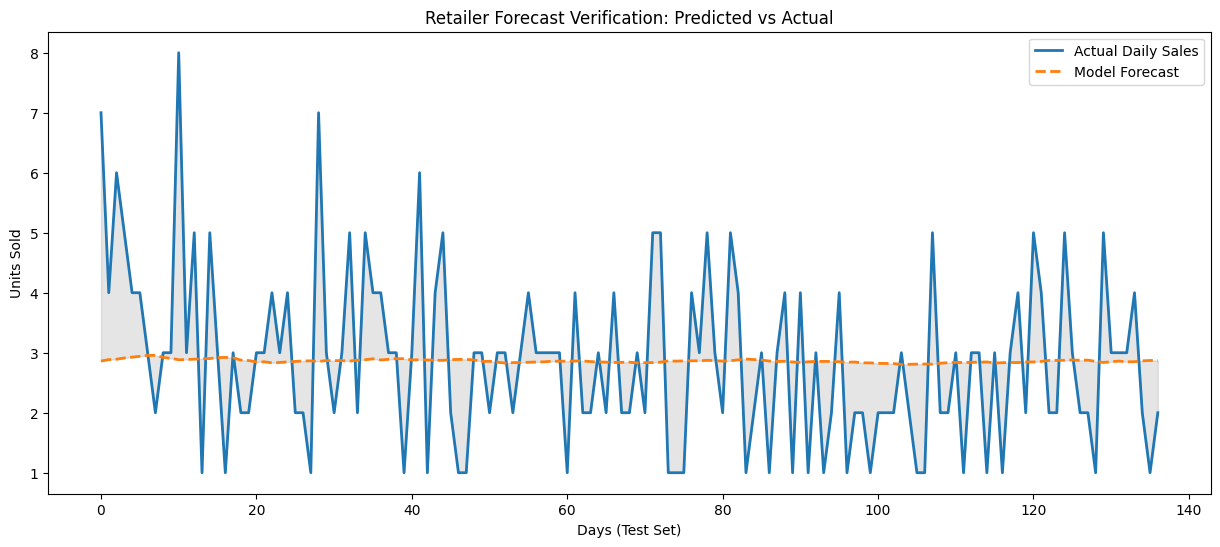

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_test_unscaled, label='Actual Daily Sales', color='#1f77b4', linewidth=2)
plt.plot(y_pred_unscaled, label='Model Forecast', color='#ff7f0e', linestyle='--', linewidth=2)
plt.fill_between(range(len(y_test_unscaled)), y_test_unscaled.flatten(), y_pred_unscaled.flatten(), color='gray', alpha=0.2)
plt.title('Retailer Forecast Verification: Predicted vs Actual')
plt.ylabel('Units Sold')
plt.xlabel('Days (Test Set)')
plt.legend()
plt.show()

In [91]:
safety_buffer = mae * 1.5
final_stock_order = tomorrow_forecast + safety_buffer

print(f"🚀 PRODUCTION READY FORECAST")
print("-" * 30)
print(f"Base Forecast: {round(tomorrow_forecast)} units")
print(f"Safety Buffer: {round(safety_buffer)} units")
print(f"TOTAL RECOMMENDED ORDER: {round(final_stock_order)} units")
print("-" * 30)

🚀 PRODUCTION READY FORECAST
------------------------------
Base Forecast: 3 units
Safety Buffer: 2 units
TOTAL RECOMMENDED ORDER: 5 units
------------------------------
